# **Finding Lane Lines on the Road** 

This report is for the Udacity Self-Driving Car NanoDegree program.   The purpose of this project is to 
summarize the work and reasoning that when into detecting lane markers and drawing guiding lines on images.

We are requested to create an image processing pipeline that can be applied to photos or videos from a source that shows
an color image of the road ahead, such as from a mounted camera. 

---

# Reflection

## Pipeline Description

The pipeline I submitted of adapted to produce reasonable guidelines in the challenge video where the lineas are curved,
there are shadows from trees, and the surface of the road changes color.

I will demonstrate the pipeline for the following image from the challenge video:

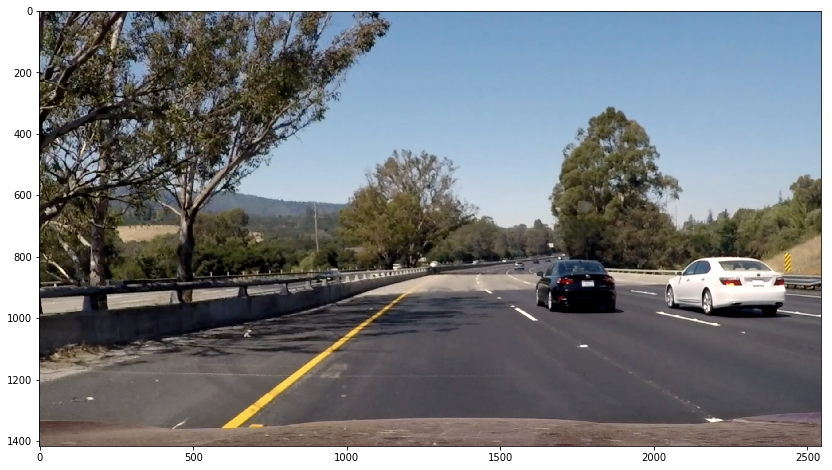

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from helper import *
%matplotlib inline

image = mpimg.imread('challenge1.png')
image = (255*image[:,:,:3]).astype(np.uint8)  #Remove alpha & convert to 8bit
plt.figure(figsize=(16,8))
plt.imshow(image)
plt.show()

## 1.  Reverse the color of the image and convert to HSV

To try to reduce the effect of shadows and lighting conditions.  I convert the image inverted image to HSV and set the value to 255.  I also set the hue to a single value, but this has no real effect on the image other than for presentation purposes because the image will be convereted to gray scale.

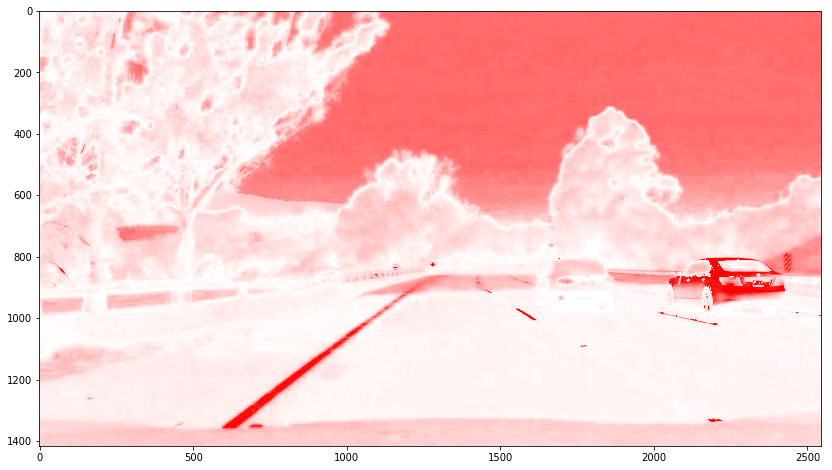

In [2]:
img_hsv = cv2.cvtColor(255-image, cv2.COLOR_RGB2HSV)
## same value
img_hsv[:,:,2] = 255
## same hue
img_hsv[:,:,0] = 0
image_convert = cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB)

plt.figure(figsize=(16,8))
plt.imshow(image_convert, cmap='gray')
plt.show()

## 2. Gray Scale and Blur Image

I then convert the image to gray scale to prepare it for edge detection

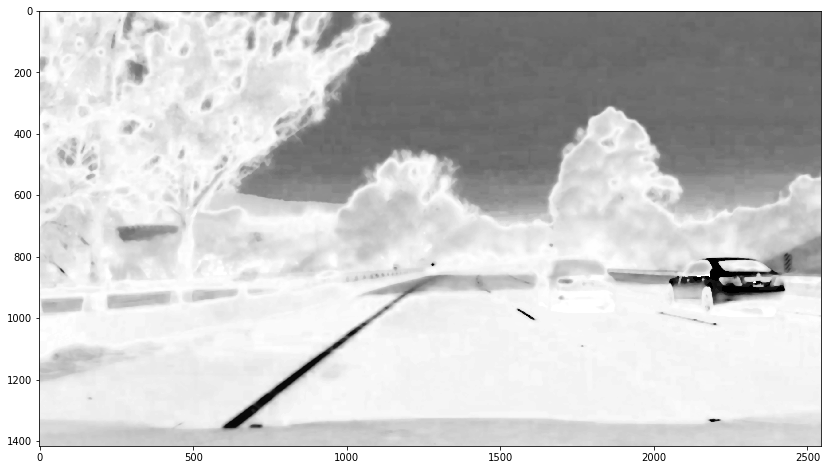

In [3]:
image_gray = cv2.cvtColor(image_convert, cv2.COLOR_RGB2GRAY)
image_blur = cv2.medianBlur(image_gray, 9) #(5, 5)), 0)
plt.figure(figsize=(16,8))
plt.imshow(image_blur, cmap='gray')
plt.show()

# 3. Edge Detection

I perform Canny Edge Detection on the image to try to identify the lanes

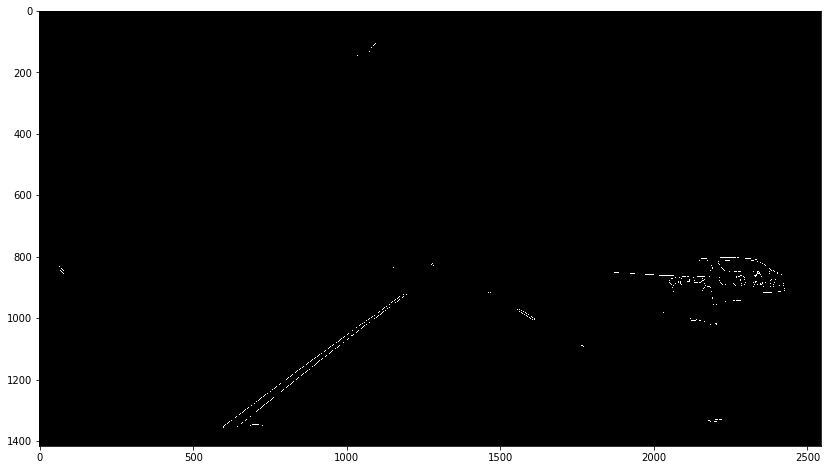

In [4]:
img_edges = cv2.Canny(image_blur, 80, 160)
plt.figure(figsize=(16,8))
plt.imshow(img_edges, cmap='gray')
plt.show()

# 4. Restrict Lane Search to bottom, center region

I make a strong assumption that lanes are in the lower half on the image and converge to the center point of the image.  I restrict the region of interest to this region.

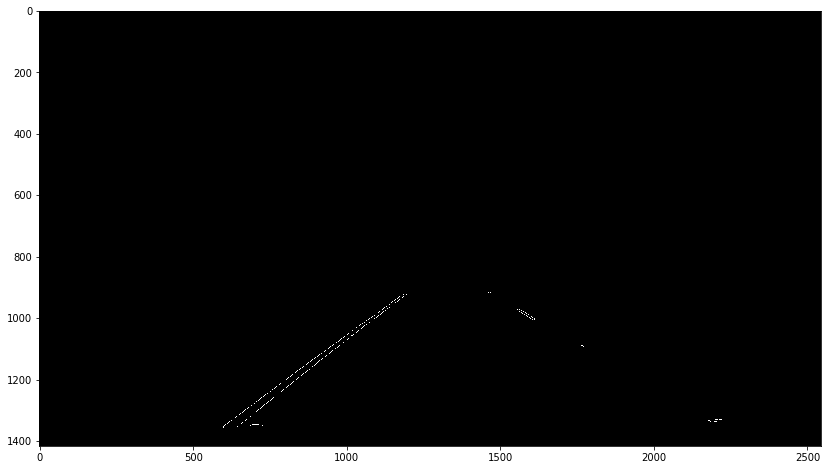

In [5]:
left_vertices, right_vertices = get_vertices(image)
img_roi_edges = region_of_interest(img_edges, left_vertices) + region_of_interest(img_edges, right_vertices)
plt.figure(figsize=(16,8))
plt.imshow(img_roi_edges, cmap='gray')
plt.show()

# 5. Perform Regression on Each Side to Draw Lines

I take the Hough Lines from the edge detection, and perform a regession on each set of lines points for the left and right side.  The the lines are then drawn on the image.

/Users/bryantravissmith/Desktop/SelfDrivingCar/CarND-LaneLines-P1/helper.py:100: RuntimeWarning: divide by zero encountered in int_scalars
  slope = (y2-y1)/(x2-x1)


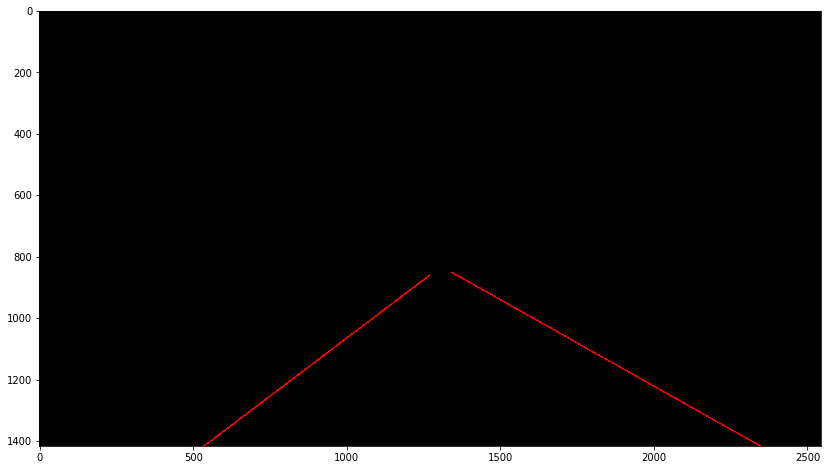

In [6]:
img_left_edges = region_of_interest(img_edges, left_vertices)
img_left_line = region_of_interest(hough_lines(img_left_edges, rho, theta, threshold, min_line_len, max_line_gap),left_vertices)

img_right_edges = region_of_interest(img_edges, right_vertices)
img_right_line = region_of_interest(hough_lines(img_right_edges, rho, theta, threshold, min_line_len, max_line_gap),right_vertices)

img_line = img_right_line + img_left_line

plt.figure(figsize=(16,8))
plt.imshow(img_line)
plt.show()

# 6. Draw Line on Original Image

Finally the image overlayed with the lines from the previous fit.

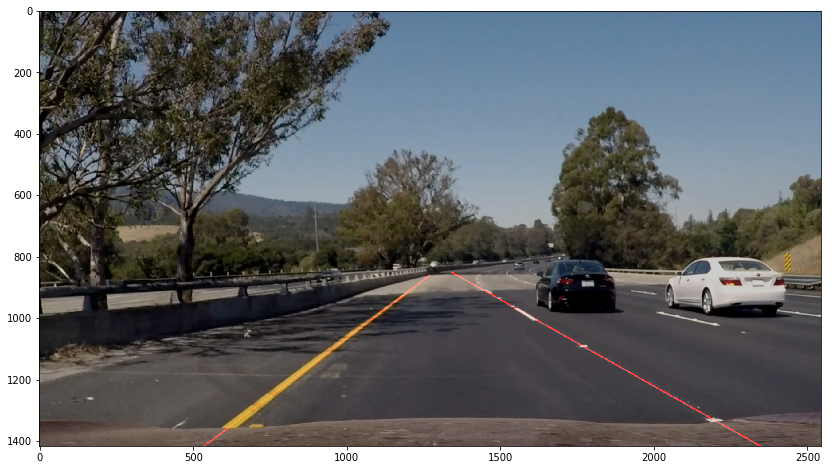

In [7]:
final_image = weighted_img(img_line, image)
plt.figure(figsize=(16,8))
plt.imshow(final_image)
plt.show()

# Shortcomings with your current pipeline

This pipeline has a number of short comings.

1.  It has only been tested on these 3 videos which
    1.  Are in the day light
    2.  Are on smooth roads with asfault
    3.  Do not have cars in front of them
    4.  Are not changing lanes or turning
    5.  Are on a high way
    6.  Do not have double lines
    7.  Are not mounted on a light colored car that appears in the frame
    8.  Are mounted in the center of the car
    
2.  The regression is a line and is refit on each image
    1. The line can jump from frame to frame
    2. It does not follow a curved road/lane

This pipeline will likely not generalize well to all driving conditions as it.

For example.  Here is a night image where it is not centered on the car:

/Users/bryantravissmith/Desktop/SelfDrivingCar/CarND-LaneLines-P1/helper.py:100: RuntimeWarning: divide by zero encountered in int_scalars
  slope = (y2-y1)/(x2-x1)


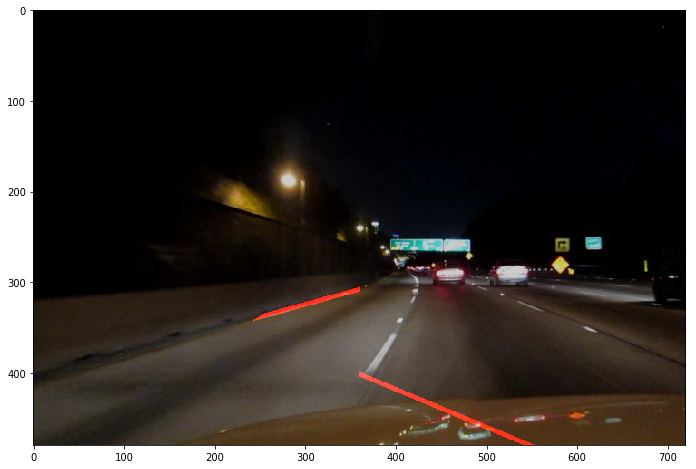

In [9]:
night1 = mpimg.imread('night_curved_road.jpg')
plt.figure(figsize=(16,8))
plt.imshow(image_pipeline(night1))
plt.show()

Here is an image with a car infront changing lanes.  The combination of the tail lights and oncoming traffic interfer with the assumption of this pipeline.

/Users/bryantravissmith/Desktop/SelfDrivingCar/CarND-LaneLines-P1/helper.py:100: RuntimeWarning: divide by zero encountered in int_scalars
  slope = (y2-y1)/(x2-x1)


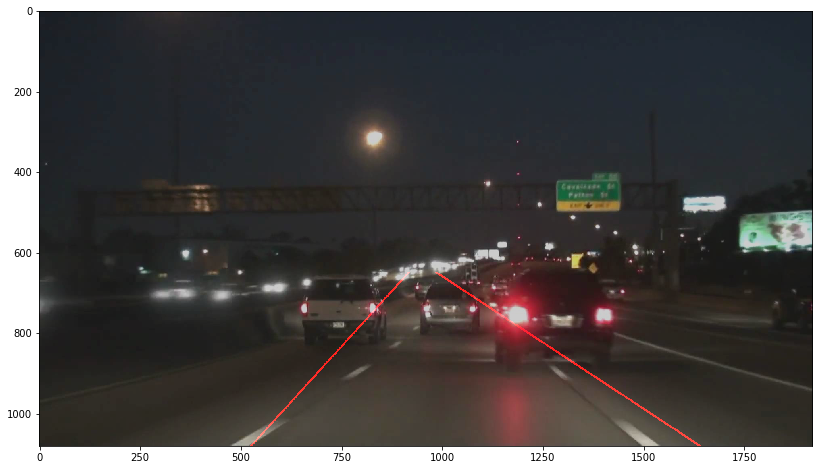

In [10]:
night1 = mpimg.imread('night_lane_change.jpg')
plt.figure(figsize=(16,8))
plt.imshow(image_pipeline(night1))
plt.show()

### 3. Suggest possible improvements to your pipeline

One easier improvement is to add a prior on the slope and intercept of the previous image to avoid large jumps from image to image.  This will allow the new slope and intercept to be biased to the previous data.  Another improvement would be to include a curve fit that would allow it to follow a curve path, rather than just straight lines. 

The preprocess of the image can likely be optimized or customized for night and heavy traffic situations.  I would need a more diverse set of photos/videos to uncover specifics.